# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [4]:
from agents.q_agent import Agent_Q
from agents.smdp_q_agent import SMDP_Agent_Q, Macro, SMDPQTable

from learning.q_learning import  q_learning
from learning.smdp_q_learning import smdp_q_learning

from learning.learning_params import *
from learning.run_learning import *

from utils.general import *
from utils.plotting import *

In [5]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

Created New Results Directory


# Towers of Hanoi - Setup

In [6]:
print(learning_parameters("Q-Learning"))
print(learning_parameters("Imitation-SMDP-Q-Learning"))

{'alpha': 0.8, 'gamma': 0.95, 'lambd': 0.1, 'epsilon': 0.1}
{'alpha': 0.8, 'gamma': 0.95, 'lambd': 0.0, 'epsilon': 0.1}


In [7]:
learning_setup = {4: {"num_episodes": 300,
                      "max_steps": 500},
                  5: {"num_episodes": 1000,
                      "max_steps": 1000},
                  6: {"num_episodes": 5000,
                      "max_steps": 2000},
                  7: {"num_episodes": 10000,
                      "max_steps": 4000},
                  8: {"num_episodes": 20000,
                      "max_steps": 8000}}

### Simple TD($\lambda$) Learning

In [8]:
# Setup for N=4 Disk Towers of Hanoi Environment
log_episodes = 10
log_freq = 20

N = 4
num_episodes = learning_setup[N]["num_episodes"]
max_steps = learning_setup[N]["max_steps"]

env = gym.make("Hanoi-v0")
env.set_env_parameters(N, env_noise=0, verbose=False)

/Users/rtl/anaconda2/envs/AG/lib/python3.6/site-packages/gym-0.10.9-py3.6.egg/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [9]:
agent = Agent_Q(env)
params = learning_parameters(l_type="Q-Learning")
hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                             **params, log_freq=log_freq,
                             log_episodes=log_episodes, verbose=True)

Ep:  1 | Avg/Std Steps: 362.50/74.41 | Avg/Std Ret: 0.00/74.41 | Success R: 0.40
Ep: 21 | Avg/Std Steps: 32.00/0.00 | Avg/Std Ret: 20.39/0.00 | Success R: 1.00
Ep: 41 | Avg/Std Steps: 32.00/0.00 | Avg/Std Ret: 20.39/0.00 | Success R: 1.00
Ep: 61 | Avg/Std Steps: 30.00/0.00 | Avg/Std Ret: 22.59/0.00 | Success R: 1.00
Ep: 81 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 101 | Avg/Std Steps: 25.00/0.00 | Avg/Std Ret: 29.20/0.00 | Success R: 1.00
Ep: 121 | Avg/Std Steps: 24.00/0.00 | Avg/Std Ret: 30.74/0.00 | Success R: 1.00
Ep: 141 | Avg/Std Steps: 26.00/0.00 | Avg/Std Ret: 27.74/0.00 | Success R: 1.00
Ep: 161 | Avg/Std Steps: 23.00/0.00 | Avg/Std Ret: 32.35/0.00 | Success R: 1.00
Ep: 181 | Avg/Std Steps: 23.00/0.00 | Avg/Std Ret: 32.35/0.00 | Success R: 1.00
Ep: 201 | Avg/Std Steps: 23.00/0.00 | Avg/Std Ret: 32.35/0.00 | Success R: 1.00
Ep: 221 | Avg/Std Steps: 23.00/0.00 | Avg/Std Ret: 32.35/0.00 | Success R: 1.00
Ep: 241 | Avg/Std Steps: 23.00/0.00 | Avg/S

In [10]:
# Run Learning 5 times for 4 Disk Environment
num_times = 5
num_disks = 4
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_4, steps_4_q, sd_steps_4_q, rew_4_q, sd_rew_4_q = run_learning("Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

4 Disks - Q-Learning: Run 1/5 Done - Time: 0.89
4 Disks - Q-Learning: Run 2/5 Done - Time: 1.46
4 Disks - Q-Learning: Run 3/5 Done - Time: 2.21
4 Disks - Q-Learning: Run 4/5 Done - Time: 0.93
4 Disks - Q-Learning: Run 5/5 Done - Time: 1.04


In [30]:
# Run Learning 5 times for 5 Disk Environment
num_disks = 5
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_5, steps_5_q, sd_steps_5_q, rew_5_q, sd_rew_5_q = run_learning("Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

5 Disks - Q-Learning: Run 1/5 Done - Time: 25.41
5 Disks - Q-Learning: Run 2/5 Done - Time: 18.4
5 Disks - Q-Learning: Run 3/5 Done - Time: 66.23
5 Disks - Q-Learning: Run 4/5 Done - Time: 36.79
5 Disks - Q-Learning: Run 5/5 Done - Time: 36.9


In [28]:
# Run Learning 5 times for 6 Disk Environment
num_disks = 6
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_6, steps_6_q, sd_steps_6_q, rew_6_q, sd_rew_6_q = run_learning("Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

6 Disks - Q-Learning: Run 1/5 Done - Time: 1165.56
6 Disks - Q-Learning: Run 2/5 Done - Time: 1128.37
6 Disks - Q-Learning: Run 3/5 Done - Time: 1076.7
6 Disks - Q-Learning: Run 4/5 Done - Time: 1072.5
6 Disks - Q-Learning: Run 5/5 Done - Time: 1051.05


In [12]:
get_rollout_policy(env, agent, max_steps, grammar=False)

deque([(0, (0, 0, 0, 0, 0), 0, (1, 0, 0, 0, 0)),
       (1, (1, 0, 0, 0, 0), 1, (1, 2, 0, 0, 0)),
       (2, (1, 2, 0, 0, 0), 3, (2, 2, 0, 0, 0)),
       (3, (2, 2, 0, 0, 0), 0, (2, 2, 1, 0, 0)),
       (4, (2, 2, 1, 0, 0), 5, (1, 2, 1, 0, 0)),
       (5, (1, 2, 1, 0, 0), 4, (1, 0, 1, 0, 0)),
       (6, (1, 0, 1, 0, 0), 2, (0, 0, 1, 0, 0)),
       (7, (0, 0, 1, 0, 0), 3, (0, 0, 2, 0, 0)),
       (8, (0, 0, 2, 0, 0), 0, (1, 0, 2, 0, 0)),
       (9, (1, 0, 2, 0, 0), 1, (1, 2, 2, 0, 0)),
       (10, (1, 2, 2, 0, 0), 3, (2, 2, 2, 0, 0)),
       (11, (2, 2, 2, 0, 0), 0, (2, 2, 2, 1, 0)),
       (12, (2, 2, 2, 1, 0), 4, (0, 2, 2, 1, 0)),
       (13, (0, 2, 2, 1, 0), 5, (0, 1, 2, 1, 0)),
       (14, (0, 1, 2, 1, 0), 1, (2, 1, 2, 1, 0)),
       (15, (2, 1, 2, 1, 0), 2, (2, 0, 2, 1, 0)),
       (16, (2, 0, 2, 1, 0), 4, (0, 0, 2, 1, 0)),
       (17, (0, 0, 2, 1, 0), 5, (0, 0, 1, 1, 0)),
       (18, (0, 0, 1, 1, 0), 1, (2, 0, 1, 1, 0)),
       (19, (2, 0, 1, 1, 0), 0, (2, 1, 1, 1, 0)),
       (20

In [13]:
get_rollout_policy(env, agent, max_steps, grammar=True)

'abdafecdabdaefbcefbafbcdbcfecdabdafecdabd'

### Check Context-Free Grammar Inference

In [14]:
optimal_policies = {4: "abdaefabdcedabd",
                    5: "bafbcdbafecfbafbcdbcfecdbafbcdb",
                    6: "abdaefabdcedabdaefaedcefabdaefabdcedabdce"\
                        "faedcedabdaefabdcedabd",
                    7: "bafbcdbafecfbafbcdbcfecdbafbcdbafecfbafec"\
                        "dbcfecfbafbcdbafecfbafbcdbcfecdbafbcdbcfe"\
                        "cfbafecdbcfecdbafbcdbafecfbafbcdbcfecdbafbcdb"}

In [15]:
from grammars.cfg_grammar import *

In [16]:
get_macros("all", optimal_policies[4], 6, "sequitur", 2)

['1 a e f 1 c e d 1 \\n ', 'a b d ']


['abd']

In [ ]:
get_macros("all", optimal_policies[4], 6, "lexis", 2)

In [17]:
os.getcwd()

'/Users/rtl/Dropbox/PHD_ECN/PROJECTS/ActionGrammars/code/grammars'

### Imitation SMDP-Q-Learning

In [18]:
log_episodes = 10
log_freq = 20

N = 4
num_episodes = learning_setup[N]["num_episodes"]
max_steps = learning_setup[N]["max_steps"]

env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0, verbose=False)

In [21]:
macros = get_optimal_macros(env, N, "Sequitur")
agent = SMDP_Agent_Q(env, macros)
params = learning_parameters(l_type="Imitation-SMDP-Q-Learning")
hist, er_buffer = smdp_q_learning(env, agent, num_episodes, max_steps,
                                  **params,
                                  log_freq=log_freq,
                                  log_episodes=log_episodes, verbose=True)

Ep:  1 | Avg/Std Steps: 261.83/156.71 | Avg/Std Ret: 7.34/156.71 | Success R: 0.60
Ep: 21 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 41 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 61 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 81 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 101 | Avg/Std Steps: 16.00/0.00 | Avg/Std Ret: 46.33/0.00 | Success R: 1.00
Ep: 121 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 141 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 161 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 181 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 201 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 221 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 241 | Avg/Std Steps: 15.00/0.00 | Avg

In [24]:
# Run Learning 5 times for 4 Disk Environment
num_times = 5
num_disks = 4
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_4, steps_4_smdp_imi, sd_steps_4_smdp_imi, rew_4_smdp_imi, sd_rew_4_smdp_imi = run_learning("Imitation-SMDP-Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

4 Disks - Imitation-SMDP-Q-Learning: Run 1/5 Done - Time: 1.12
4 Disks - Imitation-SMDP-Q-Learning: Run 2/5 Done - Time: 1.34
4 Disks - Imitation-SMDP-Q-Learning: Run 3/5 Done - Time: 1.0
4 Disks - Imitation-SMDP-Q-Learning: Run 4/5 Done - Time: 1.28
4 Disks - Imitation-SMDP-Q-Learning: Run 5/5 Done - Time: 1.09


In [23]:
# Run Learning 5 times for 5 Disk Environment
num_times = 5
num_disks = 5
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_5, steps_5_smdp_imi, sd_steps_5_smdp_imi, rew_5_smdp_imi, sd_rew_5_smdp_imi = run_learning("Imitation-SMDP-Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

5 Disks - Imitation-SMDP-Q-Learning: Run 1/5 Done - Time: 22.54
5 Disks - Imitation-SMDP-Q-Learning: Run 2/5 Done - Time: 22.41
5 Disks - Imitation-SMDP-Q-Learning: Run 3/5 Done - Time: 23.72
5 Disks - Imitation-SMDP-Q-Learning: Run 4/5 Done - Time: 21.86
5 Disks - Imitation-SMDP-Q-Learning: Run 5/5 Done - Time: 21.95


In [31]:
# Run Learning 5 times for 5 Disk Environment
num_times = 5
num_disks = 6
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_6, steps_6_smdp_imi, sd_steps_6_smdp_imi, rew_6_smdp_imi, sd_rew_6_smdp_imi = run_learning("Imitation-SMDP-Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

6 Disks - Imitation-SMDP-Q-Learning: Run 1/5 Done - Time: 753.75
6 Disks - Imitation-SMDP-Q-Learning: Run 2/5 Done - Time: 763.11
6 Disks - Imitation-SMDP-Q-Learning: Run 3/5 Done - Time: 802.51
6 Disks - Imitation-SMDP-Q-Learning: Run 4/5 Done - Time: 791.98
6 Disks - Imitation-SMDP-Q-Learning: Run 5/5 Done - Time: 765.9


In [32]:
its_all = [its_4, its_5, its_6]
steps_all = [[steps_4_q, steps_4_smdp_imi],
             [steps_5_q, steps_5_smdp_imi],
             [steps_6_q, steps_6_smdp_imi]]
sd_steps_all = [[sd_steps_4_q, sd_steps_4_smdp_imi],
                [sd_steps_5_q, sd_steps_5_smdp_imi],
                [sd_steps_6_q, sd_steps_6_smdp_imi]]
rew_all = [[rew_4_q, rew_4_smdp_imi],
           [rew_5_q, rew_5_smdp_imi],
           [rew_6_q, rew_6_smdp_imi]]
sd_rew_all = [[sd_rew_4_q, sd_rew_4_smdp_imi],
              [sd_rew_5_q, sd_rew_5_smdp_imi],
              [sd_rew_6_q, sd_rew_6_smdp_imi]]

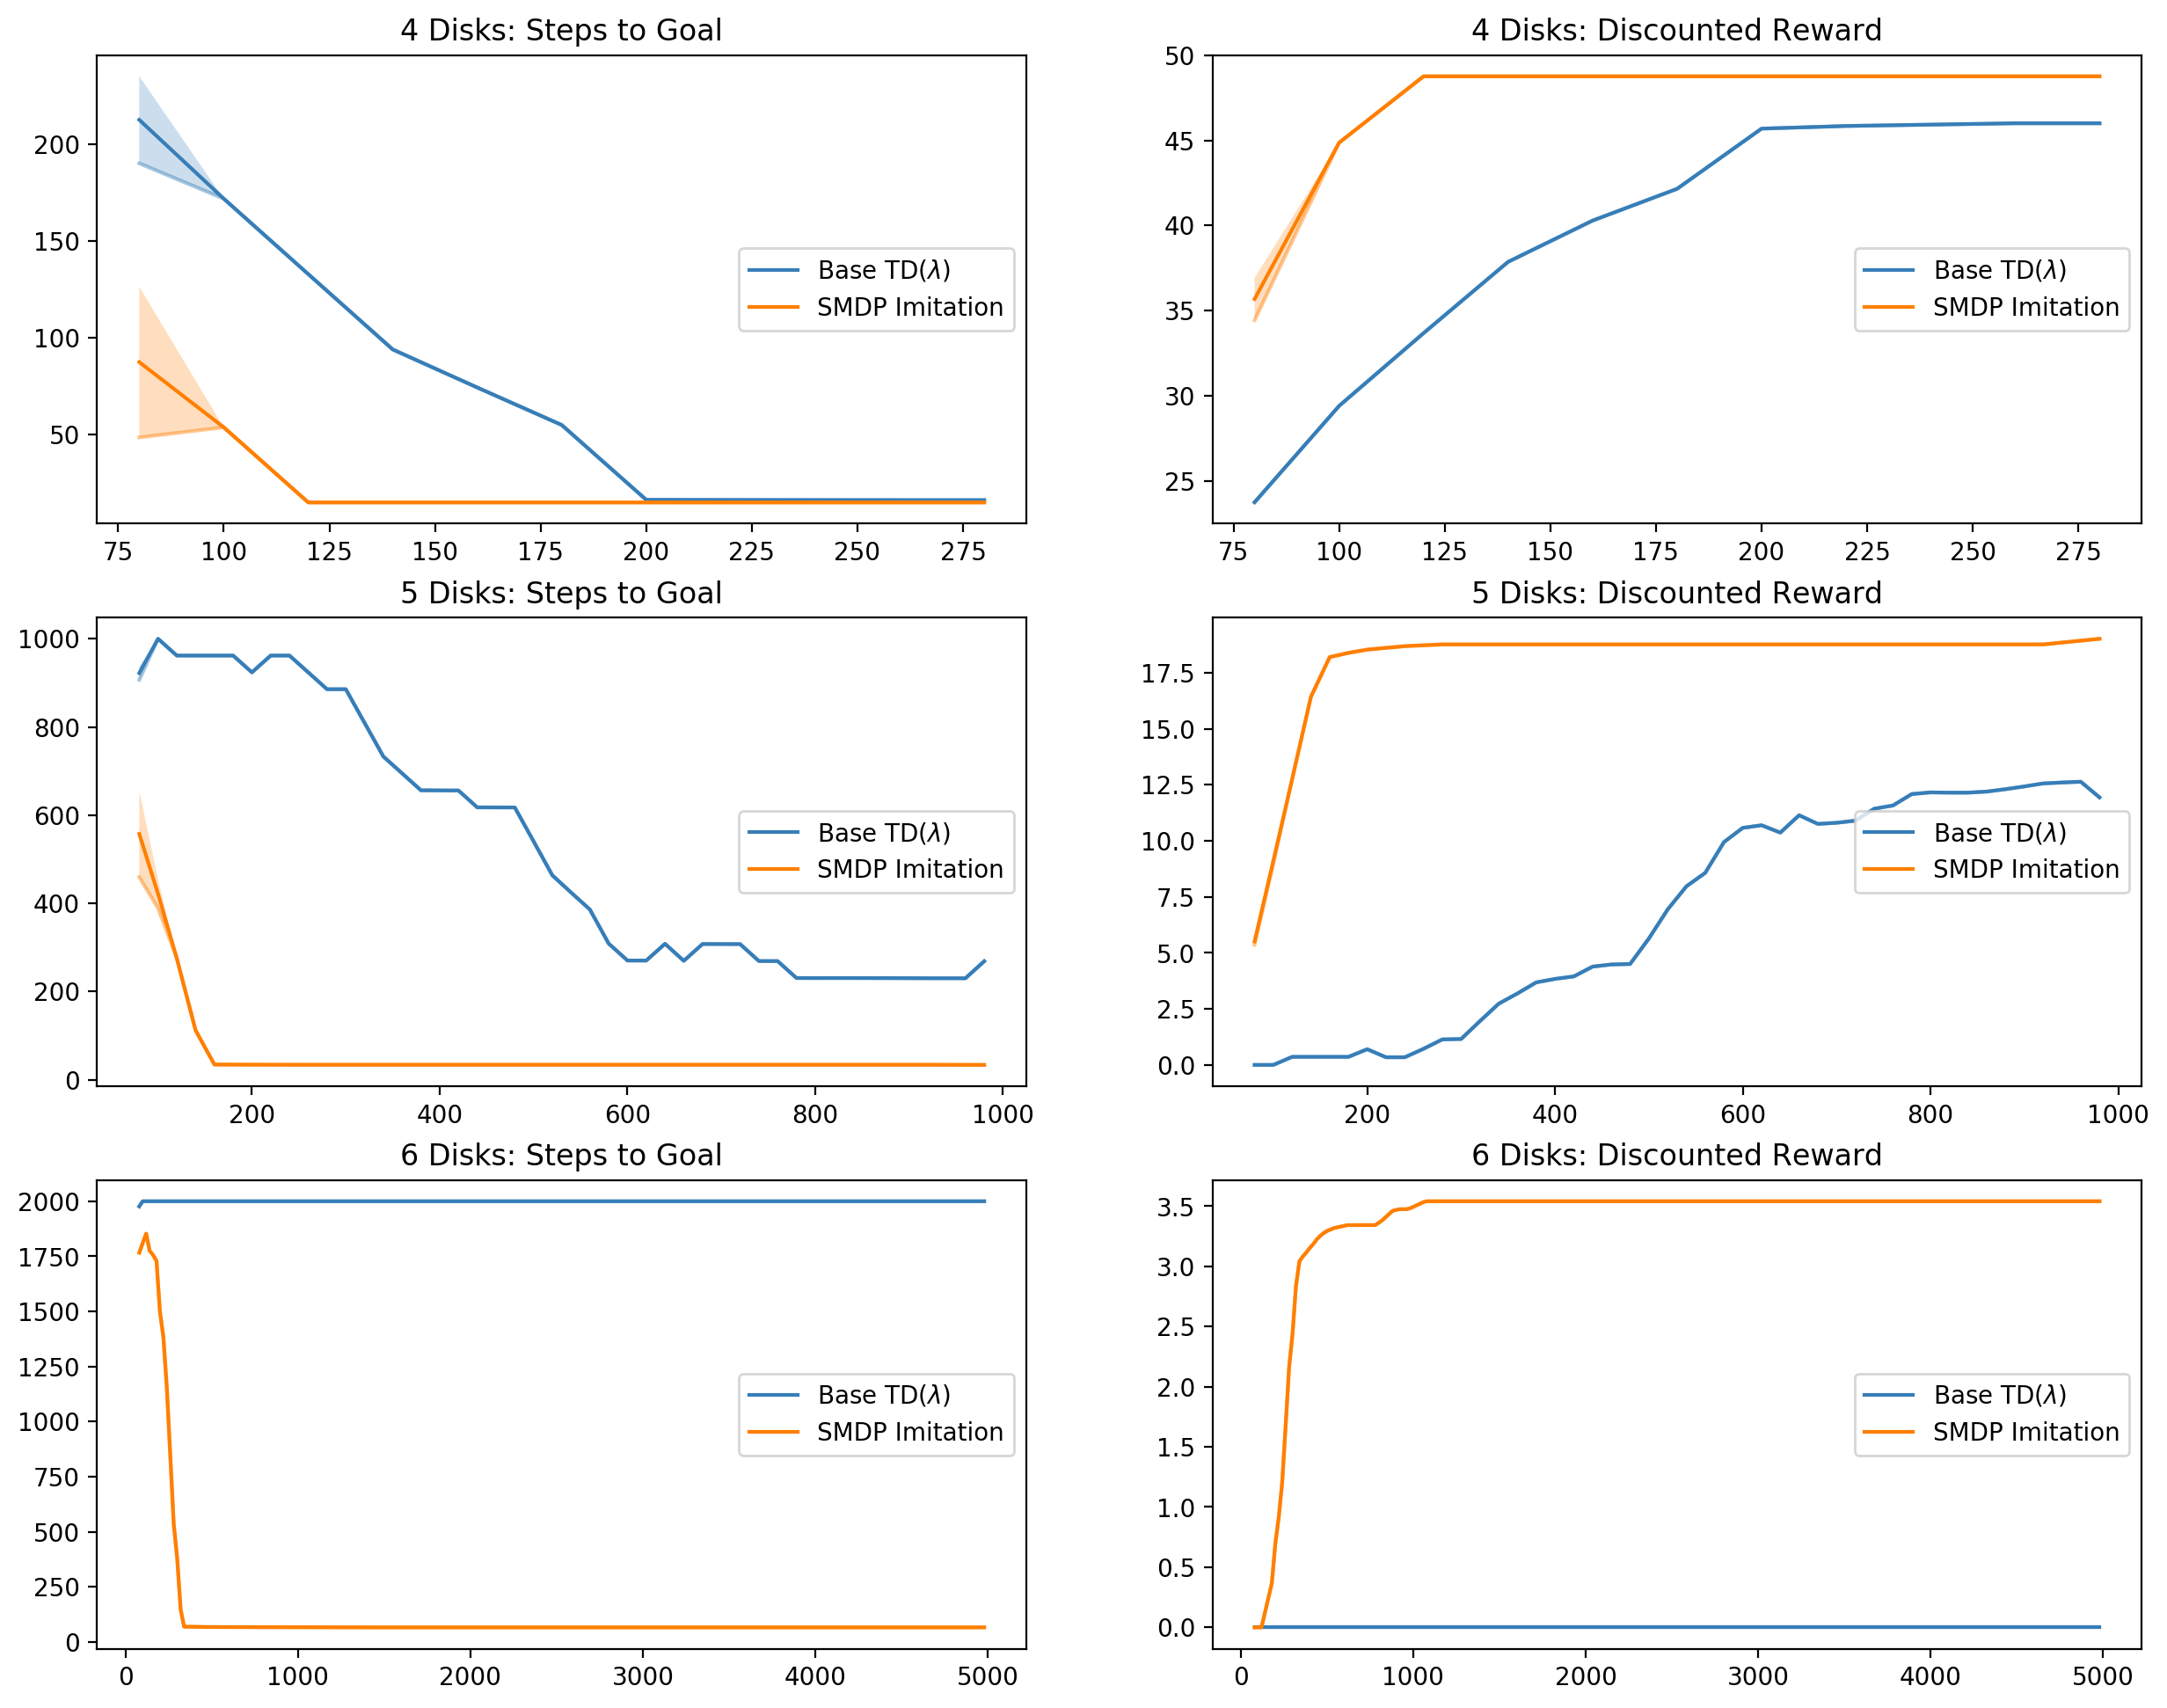

In [35]:
plot_all_learning(its_all, steps_all, sd_steps_all,
                  rew_all, sd_rew_all, smooth_degree=5,
                  labels=[r"Base TD($\lambda$)", "SMDP Imitation"])

## Transfer Learning Analysis

## Online-Grammar-Macro-SMDP Learning